# Question 2: Clustering Mitochondria

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [151]:
mito_file = pd.read_csv("http://www.webpages.uidaho.edu/~stevel/Datasets/Mt1t.mutate.csv")
mito_file.head()

,Group,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X2702,X2703,X2704,X2705,X2706,X2707,X2708,X2709,X2710,X2711
0,Position_site,3.0,10,16,18,26,35,40,41,47,...,16482,16483,16497,16509,16512,16524,16525,16526,16527,16537.0
1,CNSS,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,RSRS,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,H,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,T,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [152]:
print (mito_file.isnull().sum().sum())

601


In [153]:
mito = mito_file
# drop the first three rows
mito=mito.drop(mito.index[[0,1,2]])
# replace missing values with 0
mito.fillna(0, inplace=True)
print (mito.isnull().sum().sum())
mito_full = mito
mito = mito.drop(['Group'], axis=1)
mito.head()

0


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X2702,X2703,X2704,X2705,X2706,X2707,X2708,X2709,X2710,X2711
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
6,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
7,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


## PCA

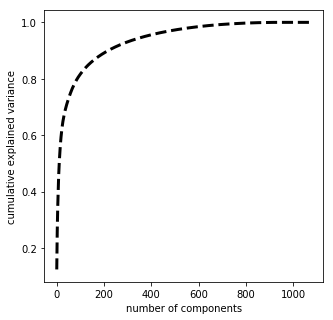

In [154]:
from sklearn.decomposition import PCA

plt.figure(figsize=(5,5))
pca = PCA().fit(mito)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'k--', linewidth=3)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

I will choose 200 components which will preserve almost 90% of the data.

In [155]:
num_components = 200

pca = PCA(n_components=num_components)
pca.fit(mito)
mito = pca.transform(mito)

## Clustering

In [156]:
print (mito_full['Group'].unique())
print ('Number of unique groups is ' + str(len(mito_full['Group'].unique())))

['H' 'T' 'X' 'J' 'U' 'K' 'I' 'W' 'V' 'R' 'M' 'B' 'N' 'Q' 'D' 'C' 'F' 'O'
 'A' 'G' 'L1b' 'S' 'L3e' 'L1' 'L0' 'L2' 'L3' 'L3h' 'L5' 'Lx' 'Ly']
Number of unique groups is 31


Because we are trying to find the haplogroups, I will choose num_clusters to be 31.

In [157]:
num_clusters = 31
labels = {}

### KMeans

In [158]:
from sklearn.cluster import KMeans

labels['kmeans'] = KMeans(n_clusters=num_clusters).fit_predict(mito)
mito_full['kmeans_clusters'] = labels['kmeans']

### Agglomerative

In [159]:
from sklearn.cluster import AgglomerativeClustering

labels['agglomerative'] = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=num_clusters).fit_predict(mito)
mito_full['agglomerative_clusters'] = labels['agglomerative']

### Spectral

In [160]:
from sklearn.cluster import SpectralClustering

labels['spectral'] = SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans', n_clusters=num_clusters).fit(mito).labels_
mito_full['spectral_clusters'] = labels['spectral']

C:\Users\Adhar Pratap Singh\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


### Gaussian Mixture Models

In [161]:
from sklearn.mixture import GaussianMixture

labels['gmm'] = GaussianMixture(n_components=num_clusters, covariance_type='full').fit_predict(mito)
mito_full['gmm_clusters'] = labels['gmm']

## Clustering Visualization

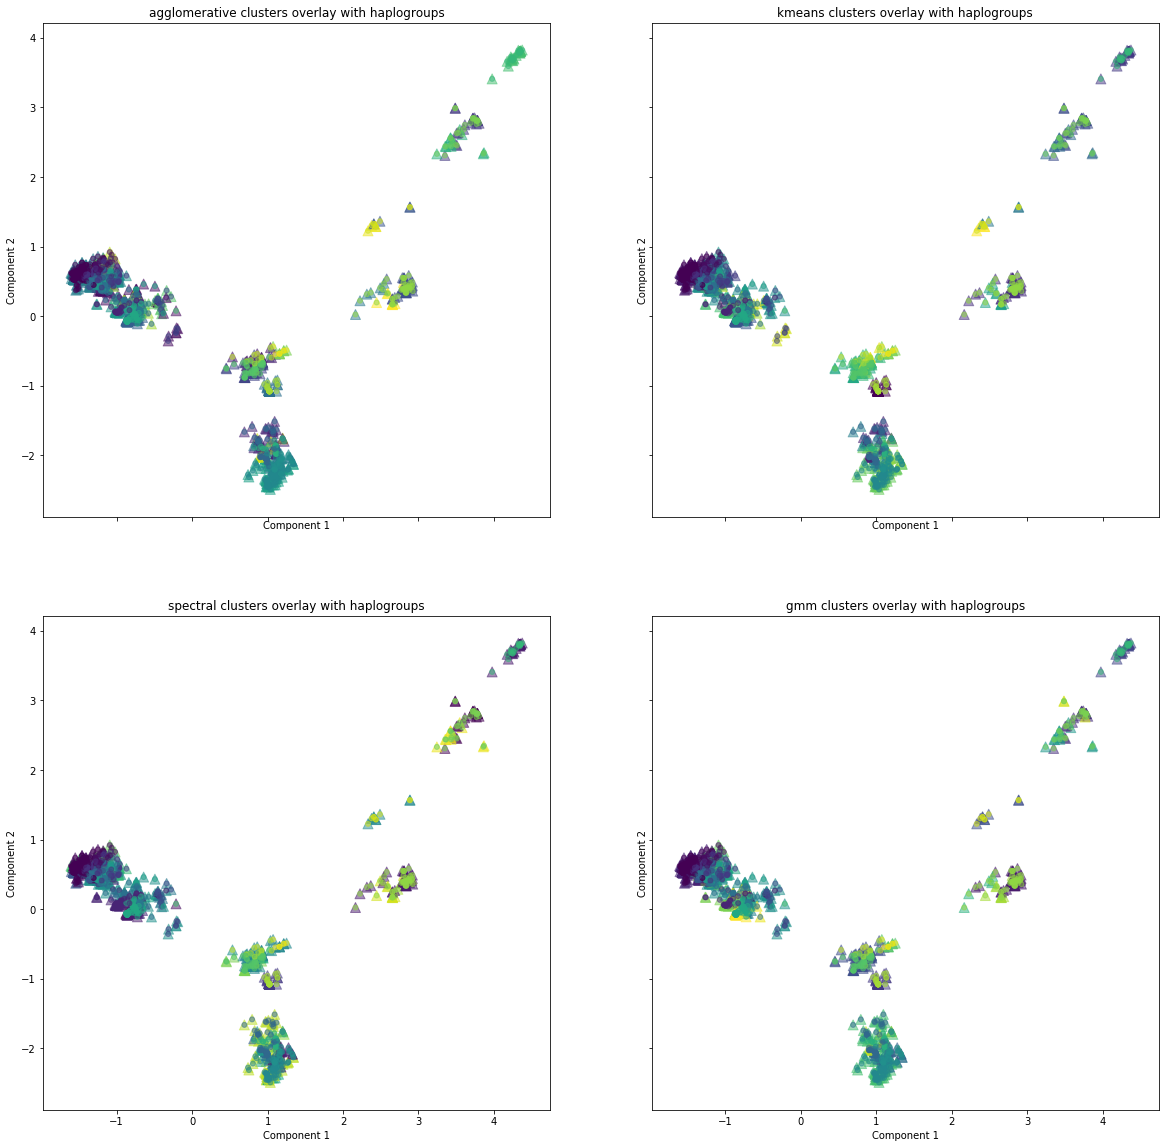

In [167]:
haplogroup_labels = {g:n for n, g in enumerate(mito_full['Group'].unique())}
fig, sub = plt.subplots(2, 2, figsize=(20, 20), sharex='col', sharey='row')
clustering_types = list(labels.keys())
for i in range(2):
    for j in range(2):
        sub[i,j].scatter(mito[:,0], mito[:,1], c=labels[clustering_types[j*2+i]], marker='^', s=100, alpha=0.5)
        sub[i,j].scatter(mito[:,0], mito[:,1], c=[haplogroup_labels[e] for e in mito_full['Group']], marker='.', s=100, alpha=0.5)
        sub[i,j].set(xlabel='Component 1', ylabel='Component 2', title=clustering_types[j*2+i]+ ' clusters overlay with haplogroups')
plt.show()

It appears that the haplogroups are similar to the clusters.

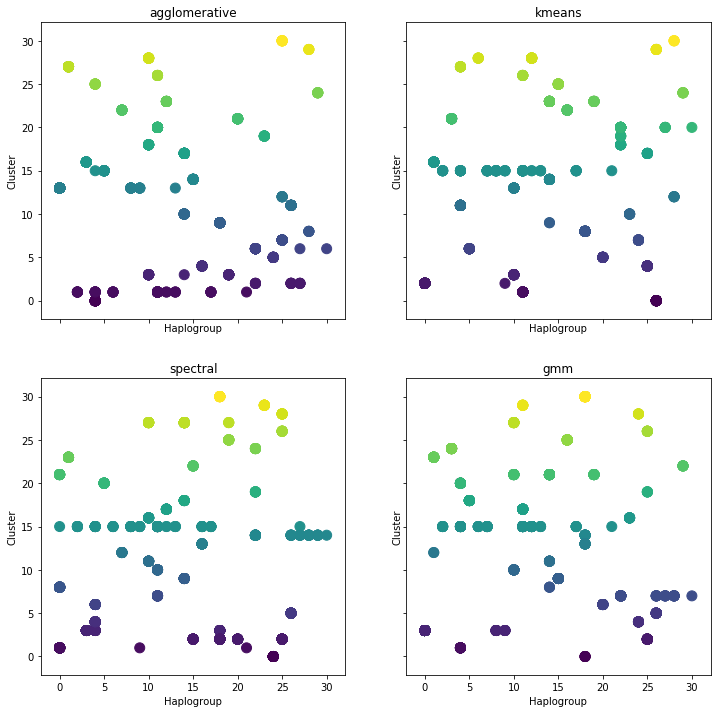

In [165]:
fig, sub = plt.subplots(2, 2, figsize=(12, 12), sharex='col', sharey='row')
for i in range(2):
    for j in range(2):
        sub[i,j].scatter([haplogroup_labels[e] for e in mito_full['Group']], mito_full[clustering_types[j*2+i] + '_clusters'], c=labels[clustering_types[j*2+i]], marker='o', s=100)
        sub[i,j].set(xlabel='Haplogroup', ylabel='Cluster', title=clustering_types[j*2+i])
plt.show()

Without seriation these graphs don't show much relationship.